In [5]:
import pandas as pd
import datetime
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine 
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
POSTGRES_ADDRESS = 'localhost' 
POSTGRES_PORT = '5432' 
POSTGRES_USERNAME = 'postgres' 
POSTGRES_PASSWORD = '***' 
POSTGRES_DBNAME = 'digital_marketing' 

In [3]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME)) 
# Create the connection 
cnx = create_engine(postgres_str)

### Q2a Analytics question: 
#### (1) Time series trend and seasonality analysis: how do different types of sales and marketing evolve over time?

##### 1(a) Trend analysis: how do sales from different order method change over time?

Here we conduct the historical time series analysis of different order methods' total sales amount to study its correlation with time. Our key findings are in below:
* Phone has historically been the dominant order method by sales amount
* Internet order has been increasing over the year and has exceeded sales by phone for the first time in 2007
* Store purchasing has also been increasing over the year, and is less affected by seasonality compared to other order methods
* Despite different levels of impact, all four order methods have a hike around Christmas time, indicating more sales volume in Christmas time. This is more significant for phone and internet orders and less significant for mail and shopping mall orders

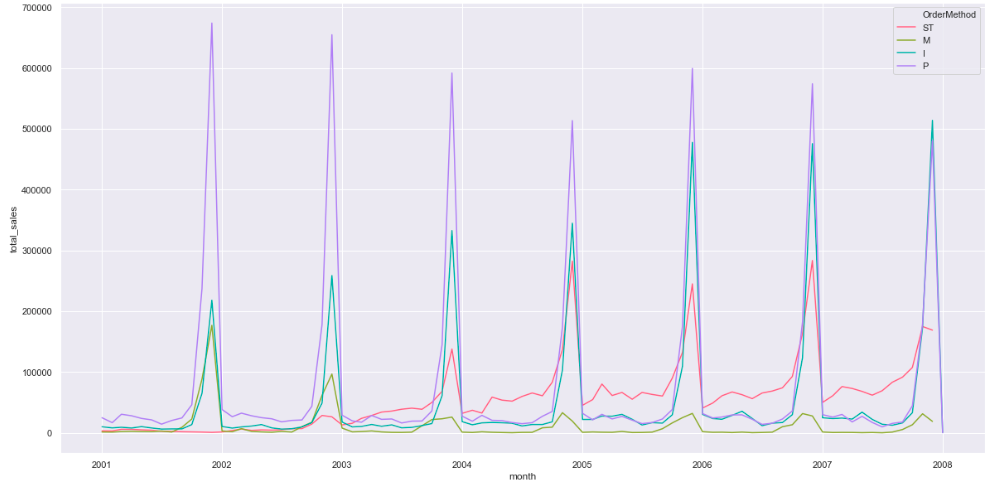

In [4]:
#Sales trend over time in different order methods
display(Image(filename='2a.1.png'))

Code: 
```SQL

df = pd.read_sql_query('''

SELECT date_trunc('month', l."OrderDate") AS month,
o."OrderMethod",
SUM(l."LineDollars") AS total_sales
FROM dataset9_lines l INNER JOIN dataset9_orders o
ON l."OrderNum" = o."OrderNum"
GROUP BY date_trunc('month', l."OrderDate"), o."OrderMethod"
ORDER BY month ASC


''', cnx)

df.set_index('month')

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x="month", y="total_sales", hue="OrderMethod", palette=sns.color_palette("husl", 4),
                    data=df)

```

##### 1(b) Trend analysis: how do sales from different order method change over time?

Here we conduct the historical time series analysis of different marketing methods' total contact number to study how the company historically conduct marketing efforts. Our key findings are in below:
* For both email and catalog marketing, there is a strong marketing effor in Christmas season with a hike in contacts
* Catalog marketing has a more stable pattern historically throughout the years. Email marketing tend to change more.

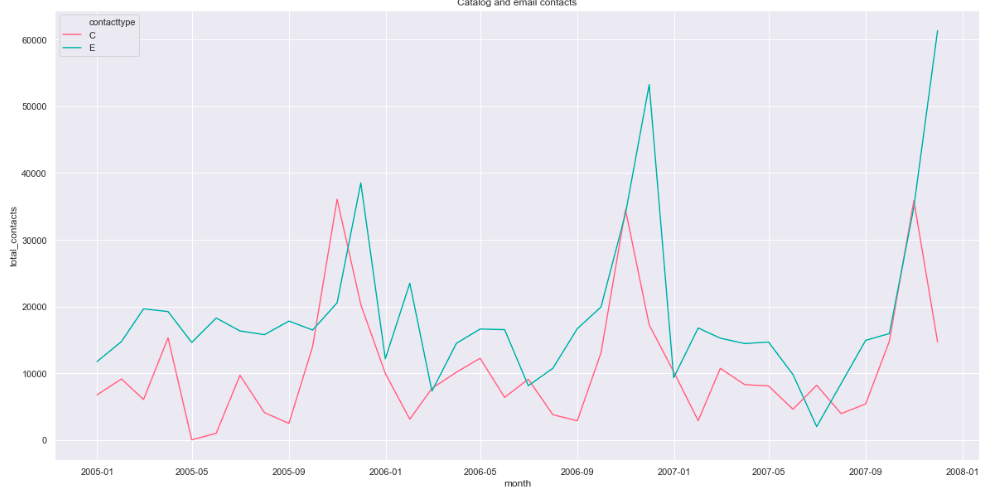

In [19]:
#Contact trend over time in different marketing approaches
display(Image(filename='2a.2.png'))

Code:    
```Python

count_contacts=pd.read_csv("2a_1.CSV")
count_contacts.set_index('month')
count_contacts['month']=pd.to_datetime(count_contacts['month'])

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Catalog and email contacts")
ax = sns.lineplot(x="month", y="total_contacts", hue="contacttype", palette=sns.color_palette("husl", 2),
                    data=count_contacts)

```

Giving that both marketing and order/sales behavior exhibit strong seasonality effect, and there exits different trend patterns of order methods and marketing efforts, it is worthwhile to study the connection between marketing and order/sales behaviors. 

As phone (P) and mail (M) are the two methods by which catalog channel orders are placed, and email marketing is most likely to impact internet (I) purchases, we can assume that catalog marketing, if works, is most likely to impact a person to place P and M orders and email marketing is most likely to impact a person to place I orders. THerefore, here comes up with our second analytical question for 2a:
#### (2) How do different marketing methods impact associated order placement/sales in Christmas and non-Christmas periods?

Here we split marketing contacts of the two groups, catalog and email, into different periods, Christmas and non-Christmas seasons. We calculate the orders, number of items purchsed as well as spending amount associated with the marketing efforts. 

Definitions/assumptions used:

* Associated orders: for catalog shopping, we consider phone and mail orders that are within 7 calendar days of contact dates; for email shopping, we consider internet orders that are within 7 calendar days of contact dates. For store orders/sales, it is difficult to relate it to one specific marketing effort so we do not consider it in this analysis.

* Response rate: total number of associated orders/total number of contacts

* Christmas season: contact date is in between Nov 01 to Dec 24 in 2005-2007.

* NChristmas season: contact date is in between Jan 01 to Oct 31 and post Dec 24 in 2005-2007. 

Our key findings are in below:
* For both email and catalog marketing, average number of orders, average number of items purchased and average spending are higher in Christmas season vs Non-Christmas season.
* For catalog marketing, average number of orders, average number of items purchased and average spending is higher than email marketing in both Christmas season vs Non-Christmas season.
* This is mainly due to higher response rate of catalog marketing compared to email marketing. However, from a per response perspective, average spending per response and average items purchased tend to be higher for catalog shopping compared to email shopping, whereas the average number of order placed per response tend to be higher for email marketing. This seem to suggest although email marketing tend to lead to slightly higher number of orders being placed, the items purchased associated with email marketing and the average spendings are less.


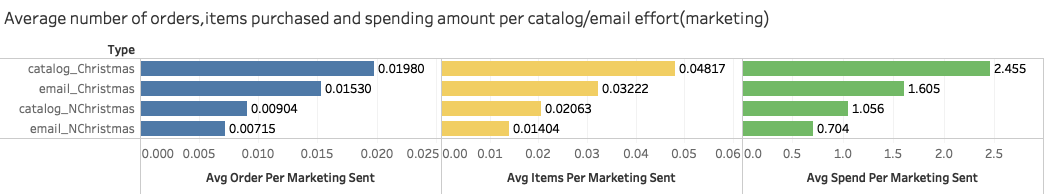

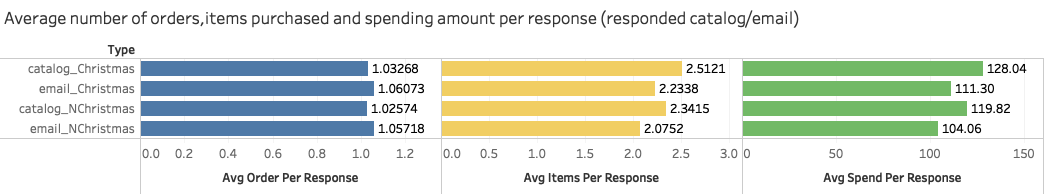

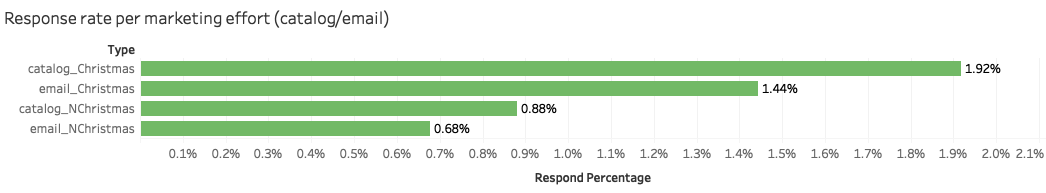

In [23]:
display(Image(filename='2a_3.png'))
display(Image(filename='2a_4.png'))
display(Image(filename='2a_5.png'))

Code:    
```SQL

1.  Christmas Catalog data
catalog_shopping: #all the lines associated with catalog shopping (ordermethod=P or M) during the time period 2005-2007
#distinct order number: 30902
#number of items/lines/rows: 61100
CREATE VIEW catalog_shopping AS
(SELECT lines.cust_id,lines.ordernum,lines.orderdate,lines.linedollars,orders.ordermethod,orders.paymenttype FROM 
lines INNER JOIN orders
ON lines.ordernum=orders.ordernum
WHERE (ordermethod='P' OR ordermethod='M') AND (lines.orderdate>'2004-12-31' AND lines.orderdate<'2008.01.01')
 )

#30902 orders (distinct ordernum)
CREATE VIEW orders_catalog AS
(SELECT * FROM orders
WHERE (ordermethod='P' OR ordermethod='M') AND (orderdate>'2004-12-31' AND orderdate<'2008.01.01')
 )
Christmas_C_contacts: #all the catalog contacts made around Christmas season in 2005-2007, defined as contacts from Nov-01 to Dec-24
#We noticed that there are catalogs send to the same customer on the same day -> assume this is duplicated data error as it is unlikely to send out two catalog to one customer on the same day, 158525 -> 157967

CREATE VIEW Christmas_C_contacts_not_clean AS
(SELECT * 
FROM contacts
WHERE contacttype='C' 
AND 
((contactdate<='2005-12-24' AND contactdate>='2005-11-01') 
 OR (contactdate<='2006-12-24' AND contactdate>='2006-11-01') 
 OR (contactdate<='2007-12-24' AND contactdate>='2007-11-01'))
)



CREATE VIEW Christmas_C_contacts AS
(SELECT cust_id, contactdate, contacttype
FROM Christmas_C_contacts_not_clean
GROUP BY cust_id, contactdate, contacttype
)


(3)  catalog_effect: to calculate the total amount of spending, total order numbers, total items bought for associated with each catalog contact: this considers any catalog shopping that is within 7 days after the catalog contact date. 
#total 157967个
CREATE VIEW Christmas_C_spend_items AS
(WITH Christmas_C_spend_items AS
(SELECT Christmas_C_contacts.cust_id, contactdate, contacttype,
SUM(CASE WHEN catalog_shopping.orderdate>contactdate AND catalog_shopping.orderdate<contactdate+7 
	THEN linedollars ELSE 0 END) OVER (PARTITION BY contactdate,Christmas_C_contacts.cust_id ) AS total_spend_catalog,
COUNT(CASE WHEN catalog_shopping.orderdate>contactdate AND catalog_shopping.orderdate<contactdate+7 
	  THEN catalog_shopping.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,Christmas_C_contacts.cust_id ) AS total_items_catalog
FROM 
(Christmas_C_contacts LEFT JOIN catalog_shopping
ON Christmas_C_contacts.cust_id=catalog_shopping.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_spend_catalog) AS total_spend_catalog, AVG(total_items_catalog) AS total_items_catalog
FROM Christmas_C_spend_items
GROUP BY cust_id, contactdate, contacttype)


CREATE VIEW Christmas_C_orders AS
(WITH Christmas_C_orders AS
(SELECT Christmas_C_contacts.cust_id, contactdate, contacttype,
COUNT(CASE WHEN orders_catalog.orderdate>contactdate AND orders_catalog.orderdate<contactdate+7 
	  THEN orders_catalog.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,Christmas_C_contacts.cust_id ) AS total_orders_catalog
FROM 
(Christmas_C_contacts LEFT JOIN orders_catalog
ON Christmas_C_contacts.cust_id=orders_catalog.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_orders_catalog) AS total_orders_catalog
FROM Christmas_C_orders
GROUP BY cust_id, contactdate, contacttype)


CREATE VIEW catalog_effect_Christmas AS
(SELECT Christmas_C_orders.cust_id, Christmas_C_orders.contactdate, Christmas_C_orders.contacttype, 
 total_orders_catalog,total_spend_catalog, total_items_catalog
FROM  
Christmas_C_orders LEFT JOIN Christmas_C_spend_items 
ON Christmas_C_orders.cust_id=Christmas_C_spend_items.cust_id AND
Christmas_C_orders.contactdate=Christmas_C_spend_items.contactdate
)

(4) get the average order, items purchased, spending amount and response rate
SELECT *, CAST(responded_orders AS NUMERIC)/CAST(total_catalogs AS NUMERIC) AS respond_percentage
FROM
(SELECT AVG(total_orders_catalog) AS avg_order_per_catalog_sent, 
AVG(total_spend_catalog) AS avg_spend_per_catalog_sent, 
AVG(total_items_catalog) AS avg_items_per_catalog_sent, 
AVG(CASE WHEN total_orders_catalog>0 THEN total_orders_catalog ELSE NULL END) AS avg_order_per_response, 
AVG(CASE WHEN total_spend_catalog>0 THEN total_spend_catalog ELSE NULL END) AS avg_spend_per_response, 
AVG(CASE WHEN total_items_catalog>0 THEN total_items_catalog ELSE NULL END) AS avg_items_per_response,
COUNT(CASE WHEN total_orders_catalog>0 THEN total_orders_catalog ELSE NULL END) AS responded_orders, COUNT(total_orders_catalog) AS total_catalogs
FROM catalog_effect_Christmas) AS catalog_effect_Christmas_calculation

2. email shopping
#53492 items
#31585 orders
CREATE VIEW email_shopping AS
(SELECT lines.cust_id,lines.ordernum,lines.orderdate,lines.linedollars,orders.ordermethod,orders.paymenttype FROM 
lines INNER JOIN orders
ON lines.ordernum=orders.ordernum
WHERE (ordermethod='I' ) AND (lines.orderdate>'2004-12-31' AND lines.orderdate<'2008.01.01')
 )

CREATE VIEW orders_email AS
(SELECT * FROM orders
WHERE (ordermethod='I') AND (orderdate>'2004-12-31' AND orderdate<'2008.01.01')
)

#227340
CREATE VIEW Christmas_E_contacts_not_clean AS
(SELECT * 
FROM contacts
WHERE contacttype='E' 
AND 
((contactdate<='2005-12-24' AND contactdate>='2005-11-01') 
 OR (contactdate<='2006-12-24' AND contactdate>='2006-11-01') 
 OR (contactdate<='2007-12-24' AND contactdate>='2007-11-01'))
)

#227191 
CREATE VIEW Christmas_E_contacts AS
(SELECT * 
FROM contacts
WHERE contacttype='E' 
AND 
((contactdate<='2005-12-24' AND contactdate>='2005-11-01') 
 OR (contactdate<='2006-12-24' AND contactdate>='2006-11-01') 
 OR (contactdate<='2007-12-24' AND contactdate>='2007-11-01'))
)

CREATE VIEW Christmas_E_contacts AS
(SELECT cust_id, contactdate, contacttype
FROM Christmas_E_contacts_not_clean
GROUP BY cust_id, contactdate, contacttype
)

CREATE VIEW Christmas_E_spend_items AS
(WITH Christmas_E_spend_items AS
(SELECT Christmas_E_contacts.cust_id, contactdate, contacttype,
SUM(CASE WHEN email_shopping.orderdate>contactdate AND email_shopping.orderdate<contactdate+7 
	THEN linedollars ELSE 0 END) OVER (PARTITION BY contactdate,Christmas_E_contacts.cust_id ) AS total_spend_email,
COUNT(CASE WHEN email_shopping.orderdate>contactdate AND email_shopping.orderdate<contactdate+7 
	  THEN email_shopping.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,Christmas_E_contacts.cust_id ) AS total_items_email
FROM 
(Christmas_E_contacts LEFT JOIN email_shopping
ON Christmas_E_contacts.cust_id=email_shopping.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_spend_email) AS total_spend_email, AVG(total_items_email) AS total_items_email
FROM Christmas_E_spend_items
GROUP BY cust_id, contactdate, contacttype)



CREATE VIEW Christmas_E_orders AS
(WITH Christmas_E_orders AS
(SELECT Christmas_E_contacts.cust_id, contactdate, contacttype,
COUNT(CASE WHEN orders_email.orderdate>contactdate AND orders_email.orderdate<contactdate+7 
	  THEN orders_email.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,Christmas_E_contacts.cust_id ) AS total_orders_email
FROM 
(Christmas_E_contacts LEFT JOIN orders_email
ON Christmas_E_contacts.cust_id=orders_email.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_orders_email) AS total_orders_email
FROM Christmas_E_orders
GROUP BY cust_id, contactdate, contacttype)

CREATE VIEW email_effect_Christmas AS
(SELECT Christmas_E_orders.cust_id, Christmas_E_orders.contactdate, Christmas_E_orders.contacttype, 
 total_orders_email,total_spend_email, total_items_email
FROM  
Christmas_E_orders LEFT JOIN Christmas_E_spend_items 
ON Christmas_E_orders.cust_id=Christmas_E_spend_items.cust_id AND
Christmas_E_orders.contactdate=Christmas_E_spend_items.contactdate
)

SELECT *, CAST(responded_orders AS NUMERIC)/CAST(total_emails AS NUMERIC) AS respond_percentage
FROM
(SELECT AVG(total_orders_email) AS avg_order_per_email_sent, 
AVG(total_spend_email) AS avg_spend_per_email_sent, 
AVG(total_items_email) AS avg_items_per_email_sent, 
AVG(CASE WHEN total_orders_email>0 THEN total_orders_email ELSE NULL END) AS avg_order_per_response, 
AVG(CASE WHEN total_spend_email>0 THEN total_spend_email ELSE NULL END) AS avg_spend_per_response, 
AVG(CASE WHEN total_items_email>0 THEN total_items_email ELSE NULL END) AS avg_items_per_response,
COUNT(CASE WHEN total_orders_email>0 THEN total_orders_email ELSE NULL END) AS responded_orders, COUNT(total_orders_email) AS total_emails
FROM email_effect_Christmas) AS email_effect_Christmas_calculation


3. Catalog-Non Christmas
 CREATE VIEW NChristmas_C_contacts_not_clean AS
(SELECT * 
FROM contacts
WHERE contacttype='C' 
AND 
((contactdate>'2005-12-24' AND contactdate>'2006-11-01') 
 OR (contactdate>'2006-12-24' AND contactdate<'2007-11-01') 
 OR (contactdate<'2005-11-01' OR contactdate>='2007-12-24'))
)



CREATE VIEW NChristmas_C_contacts AS
(SELECT cust_id, contactdate, contacttype
FROM NChristmas_C_contacts_not_clean
GROUP BY cust_id, contactdate, contacttype
)

CREATE VIEW NChristmas_C_spend_items AS
(WITH NChristmas_C_spend_items AS
(SELECT NChristmas_C_contacts.cust_id, contactdate, contacttype,
SUM(CASE WHEN catalog_shopping.orderdate>contactdate AND catalog_shopping.orderdate<contactdate+7 
	THEN linedollars ELSE 0 END) OVER (PARTITION BY contactdate,NChristmas_C_contacts.cust_id ) AS total_spend_catalog,
COUNT(CASE WHEN catalog_shopping.orderdate>contactdate AND catalog_shopping.orderdate<contactdate+7 
	  THEN catalog_shopping.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,NChristmas_C_contacts.cust_id ) AS total_items_catalog
FROM 
(NChristmas_C_contacts LEFT JOIN catalog_shopping
ON NChristmas_C_contacts.cust_id=catalog_shopping.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_spend_catalog) AS total_spend_catalog, AVG(total_items_catalog) AS total_items_catalog
FROM NChristmas_C_spend_items
GROUP BY cust_id, contactdate, contacttype)


CREATE VIEW NChristmas_C_orders AS
(WITH NChristmas_C_orders AS
(SELECT NChristmas_C_contacts.cust_id, contactdate, contacttype,
COUNT(CASE WHEN orders_catalog.orderdate>contactdate AND orders_catalog.orderdate<contactdate+7 
	  THEN orders_catalog.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,NChristmas_C_contacts.cust_id ) AS total_orders_catalog
FROM 
(NChristmas_C_contacts LEFT JOIN orders_catalog
ON NChristmas_C_contacts.cust_id=orders_catalog.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_orders_catalog) AS total_orders_catalog
FROM NChristmas_C_orders
GROUP BY cust_id, contactdate, contacttype)

CREATE VIEW catalog_effect_NChristmas AS
(SELECT NChristmas_C_orders.cust_id, NChristmas_C_orders.contactdate, NChristmas_C_orders.contacttype, 
 total_orders_catalog,total_spend_catalog, total_items_catalog
FROM  
NChristmas_C_orders LEFT JOIN NChristmas_C_spend_items 
ON NChristmas_C_orders.cust_id=NChristmas_C_spend_items.cust_id AND
NChristmas_C_orders.contactdate=NChristmas_C_spend_items.contactdate
)

SELECT *, CAST(responded_orders AS NUMERIC)/CAST(total_catalogs AS NUMERIC) AS respond_percentage
FROM
(SELECT AVG(total_orders_catalog) AS avg_order_per_catalog_sent, 
AVG(total_spend_catalog) AS avg_spend_per_catalog_sent, 
AVG(total_items_catalog) AS avg_items_per_catalog_sent, 
AVG(CASE WHEN total_orders_catalog>0 THEN total_orders_catalog ELSE NULL END) AS avg_order_per_response, 
AVG(CASE WHEN total_spend_catalog>0 THEN total_spend_catalog ELSE NULL END) AS avg_spend_per_response, 
AVG(CASE WHEN total_items_catalog>0 THEN total_items_catalog ELSE NULL END) AS avg_items_per_response,
COUNT(CASE WHEN total_orders_catalog>0 THEN total_orders_catalog ELSE NULL END) AS responded_orders, COUNT(total_orders_catalog) AS total_catalogs
FROM catalog_effect_NChristmas) AS catalog_effect_NChristmas_calculation

4. Email-Non Christmas
CREATE VIEW NChristmas_E_contacts_not_clean AS
(SELECT * 
FROM contacts
WHERE contacttype='E' 
AND 
((contactdate>'2005-12-24' AND contactdate>'2006-11-01') 
 OR (contactdate>'2006-12-24' AND contactdate<'2007-11-01') 
 OR (contactdate<'2005-11-01' OR contactdate>='2007-12-24'))
)


CREATE VIEW NChristmas_E_contacts AS
(SELECT * 
FROM contacts
WHERE contacttype='E' 
AND 
((contactdate<='2005-12-24' AND contactdate>='2005-11-01') 
 OR (contactdate<='2006-12-24' AND contactdate>='2006-11-01') 
 OR (contactdate<='2007-12-24' AND contactdate>='2007-11-01'))
)

CREATE VIEW NChristmas_E_contacts AS
(SELECT cust_id, contactdate, contacttype
FROM NChristmas_E_contacts_not_clean
GROUP BY cust_id, contactdate, contacttype
)

CREATE VIEW NChristmas_E_spend_items AS
(WITH NChristmas_E_spend_items AS
(SELECT NChristmas_E_contacts.cust_id, contactdate, contacttype,
SUM(CASE WHEN email_shopping.orderdate>contactdate AND email_shopping.orderdate<contactdate+7 
	THEN linedollars ELSE 0 END) OVER (PARTITION BY contactdate,NChristmas_E_contacts.cust_id ) AS total_spend_email,
COUNT(CASE WHEN email_shopping.orderdate>contactdate AND email_shopping.orderdate<contactdate+7 
	  THEN email_shopping.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,NChristmas_E_contacts.cust_id ) AS total_items_email
FROM 
(NChristmas_E_contacts LEFT JOIN email_shopping
ON NChristmas_E_contacts.cust_id=email_shopping.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_spend_email) AS total_spend_email, AVG(total_items_email) AS total_items_email
FROM NChristmas_E_spend_items
GROUP BY cust_id, contactdate, contacttype)



CREATE VIEW NChristmas_E_orders AS
(WITH NChristmas_E_orders AS
(SELECT NChristmas_E_contacts.cust_id, contactdate, contacttype,
COUNT(CASE WHEN orders_email.orderdate>contactdate AND orders_email.orderdate<contactdate+7 
	  THEN orders_email.ordernum ELSE NULL END) OVER (PARTITION BY contactdate,NChristmas_E_contacts.cust_id ) AS total_orders_email
FROM 
(NChristmas_E_contacts LEFT JOIN orders_email
ON NChristmas_E_contacts.cust_id=orders_email.cust_id)
)
SELECT cust_id, contactdate, contacttype, AVG(total_orders_email) AS total_orders_email
FROM NChristmas_E_orders
GROUP BY cust_id, contactdate, contacttype)

CREATE VIEW email_effect_NChristmas AS
(SELECT NChristmas_E_orders.cust_id, NChristmas_E_orders.contactdate, NChristmas_E_orders.contacttype, 
 total_orders_email,total_spend_email, total_items_email
FROM  
NChristmas_E_orders LEFT JOIN NChristmas_E_spend_items 
ON NChristmas_E_orders.cust_id=NChristmas_E_spend_items.cust_id AND
NChristmas_E_orders.contactdate=NChristmas_E_spend_items.contactdate
)

SELECT *, CAST(responded_orders AS NUMERIC)/CAST(total_emails AS NUMERIC) AS respond_percentage
FROM
(SELECT AVG(total_orders_email) AS avg_order_per_email_sent, 
AVG(total_spend_email) AS avg_spend_per_email_sent, 
AVG(total_items_email) AS avg_items_per_email_sent, 
AVG(CASE WHEN total_orders_email>0 THEN total_orders_email ELSE NULL END) AS avg_order_per_response, 
AVG(CASE WHEN total_spend_email>0 THEN total_spend_email ELSE NULL END) AS avg_spend_per_response, 
AVG(CASE WHEN total_items_email>0 THEN total_items_email ELSE NULL END) AS avg_items_per_response,
COUNT(CASE WHEN total_orders_email>0 THEN total_orders_email ELSE NULL END) AS responded_orders, COUNT(total_orders_email) AS total_emails
FROM email_effect_NChristmas) AS email_effect_NChristmas_calculation

```